<a href="https://colab.research.google.com/github/cerasole/EnvironmentalRadioactivity/blob/main/Notebooks/SpectralFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi dello spettro ambientale di un rivelatore a scintillazione a NaI(Tl)

In questo notebook viene mostrata un'analisi standard di calibrazione, studio dei picchi della radioattività ambientale e risoluzione energetica di un rivelatore basato sullo ioduro di sodio.

In [ ]:
#

## Step 0 - Download dei file ed import dei moduli necessari

In [1]:
!pip install iminuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 5.3 MB/s eta 0:00:00


In [2]:
import os, glob
import glob
import numpy as np

# Funzioni per la visualizzazione
import matplotlib.pyplot as plt
plt.rc("font", size = 16)

# Funzioni per i fit
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [37]:
!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/1.txt
#!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/2.txt
#!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/3.txt
#!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/4.txt
#!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/5.txt

--2025-03-04 05:26:48--  https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/Posto1/1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66469 (65K) [text/plain]
Saving to: ‘1.txt.1’

1.txt.1             100%[===================>]  64.91K  --.-KB/s    in 0.02s   

2025-03-04 05:26:48 (3.01 MB/s) - ‘1.txt.1’ saved [66469/66469]



## Step 1 - Lettura e prima esplorazione dello spettro

Il file contiene l'istogramma dei conteggi in ADC acquisiti in 5 minuti.

In [39]:
file = "1.txt"

adc, counts = np.loadtxt(file, unpack = True, skiprows = 14)
adc, counts

(array([0.000e+00, 1.000e+00, 2.000e+00, ..., 8.189e+03, 8.190e+03,
        8.191e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

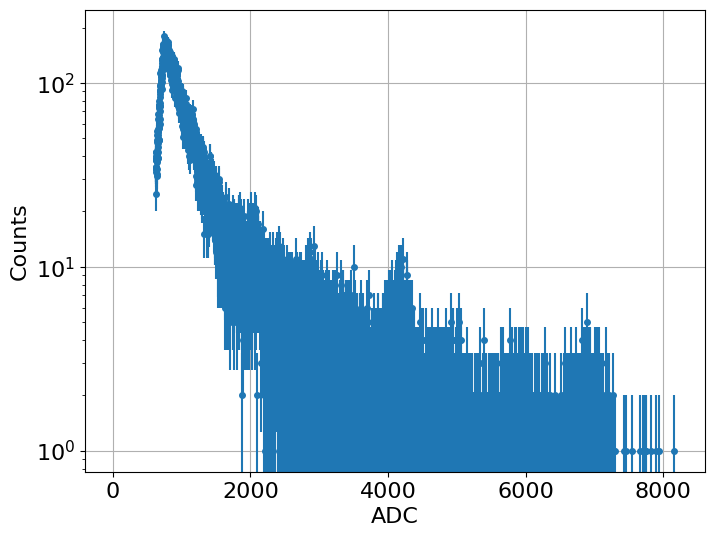

In [40]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    adc,
    counts,
    xerr = (adc[1] - adc[0])/2,
    yerr = np.sqrt(counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("ADC")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.grid()

In [8]:
### Conteggio totale!

np.sum(counts)

79324.0

## Step 2 - Rebin dell'istogramma

L'istogramma mostrato nella figura precedente risulta essere molto confusionario, in quanto ci sono troppi bin. Effettuiamo un opportuno rebin.

Si noti che la dimensione ottimale del rebinnaggio può dipendere dall'intervallo di energie con cui si sta lavorando. Se siamo interessati alle basse energie, ove la statistica è più ricca, potrebbe bastarci anche un rebin di un fattore 8.
Invece, se ci interessano le alte energie conviene effettuare un rebinnaggio con un fattore di rebin più ampio

In [41]:
# Questa è la funzione che mi è stata suggerita dall'AI di Colab
def rebin_histogram (bins, values, rebin):
  new_bins = bins[::rebin]
  new_values = np.sum(values.reshape(-1, rebin), axis = 1)
  return new_bins, new_values

# Questa è la funzione che scriverei io!
def rebin_histogram(bins, values, rebin):
  N = len(bins)
  new_N = int(N // rebin)
  new_bins, new_values = np.zeros(new_N), np.zeros(new_N)
  for i in range(new_N):
    new_bins[i] = np.mean(bins[i*rebin:(i+1)*rebin])
    new_values[i] = np.sum(values[i*rebin:(i+1)*rebin])
  return new_bins, new_values

rebinned_adc, rebinned_counts = rebin_histogram(adc, counts, 24)

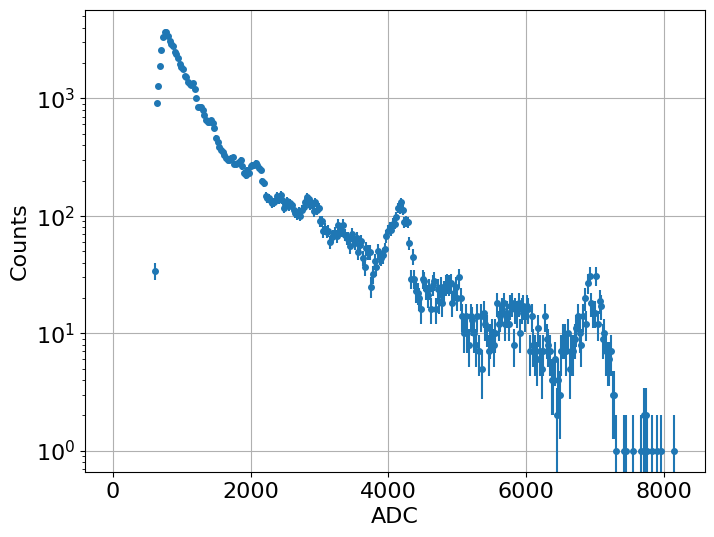

In [43]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    rebinned_adc,
    rebinned_counts,
    xerr = (rebinned_adc[1] - rebinned_adc[0])/2,
    yerr = np.sqrt(rebinned_counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("ADC")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.grid()

## Step 3 - Calibrazione lineare

Adesso dobbiamo individuare alcuni picchi e procedere ad una calibrazione per convertire gli ADC in energia!



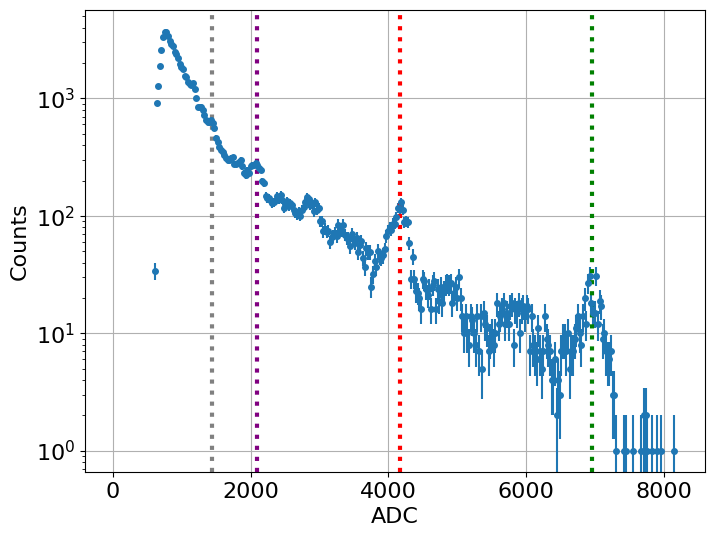

In [28]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    rebinned_adc,
    rebinned_counts,
    xerr = (rebinned_adc[1] - rebinned_adc[0])/2,
    yerr = np.sqrt(rebinned_counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("ADC")
ax.set_ylabel("Counts")
ax.set_yscale("log")
# Focus su alcuni picchi a bassa energia
#ax.set_xlim(1000, 3300)
#ax.set_ylim(50, 2000)
ax.axvline(1440, ls = "dotted", color = "gray", lw = 3) # Picco del Pb-214 a 352 keV
ax.axvline(2090, ls = "dotted", color = "purple", lw = 3) # Picco del Tl-208 a 609 keV
# Focus su alcuni picchi ad alta energia
#ax.set_xlim(3500, 8000)
#ax.set_ylim(1, 220)
ax.axvline(4170, ls = "dotted", color = "red", lw = 3) # Picco del Co-60 a 1460 keV
ax.axvline(6960, ls = "dotted", color = "green", lw = 3) # Picco del Tl-208 o 2614 keV
ax.grid()

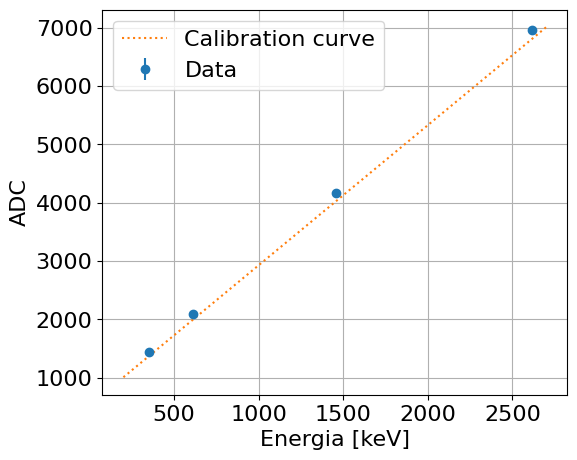

In [29]:
# Calibrazione = conversione da ADC ad energia
adc_peaks = np.array([1440, 2090, 4170, 6960])
adc_peaks_err = np.array([10, 20, 30, 40])
keV_peaks = np.array([352, 609, 1460, 2614])

fig, ax = plt.subplots(figsize = (6, 5))

x = np.linspace(200, 2700)
p0, p1 = 528, 2.4
y = p0 + p1*x

ax.errorbar(
    keV_peaks,
    adc_peaks,
    yerr = adc_peaks_err,
    ls = "None",
    marker = "o",
    label = "Data"
)
ax.plot(x, y, ls = "dotted", label = "Calibration curve")
ax.legend()
plt.xlabel("Energia [keV]")
plt.ylabel("ADC")
plt.grid();

In [30]:
def linear_function (x, p0, p1):
  return p0 + p1*x

loss = LeastSquares(x=keV_peaks, y=adc_peaks, yerror=adc_peaks_err, model = linear_function)
m = Minuit(loss, p0=528, p1=2.4)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.358 (χ²/ndof = 0.7)      │              Nfcn = 41               │
│ EDM = 1.3e-18 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │    583    │    12     │            │            │         │         │       │
│ 1 │ p1   │   2.447   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────┐
│    │         p0         p1 │
├────┼───────────────────────┤
│ p0 │        156 -146.90e-3 │
│ p1 │ -146.90e-3   0.000252 │
└────┴───────────────────────┘

In [32]:
p0, p1 = m.params[0].value, m.params[1].value
p0, p1

(583.0985018297508, 2.447110471513173)

In [44]:
rebinned_energy = (rebinned_adc - p0) / p1

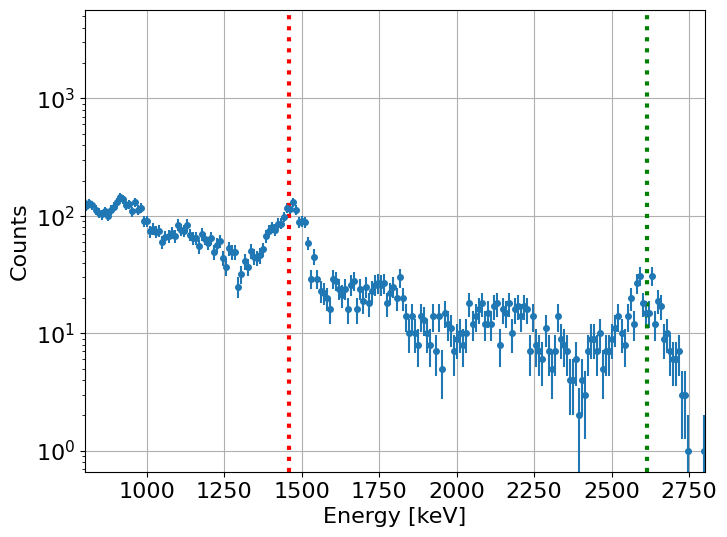

In [56]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(
    rebinned_energy,
    rebinned_counts,
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts),
    ls = "None",
    marker = "o",
    markersize = 4
)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Counts")
ax.set_yscale("log")
# Focus su alcuni picchi a bassa energia
#ax.set_xlim(100, 900)
#ax.set_ylim(100, 2000)
ax.axvline(352, ls = "dotted", color = "gray", lw = 3) # Picco del Pb-214 a 352 keV
ax.axvline(609, ls = "dotted", color = "purple", lw = 3) # Picco del Tl-208 a 609 keV
# Focus su alcuni picchi ad alta energia
ax.set_xlim(800, 2800)
#ax.set_ylim(1, 120)
ax.axvline(1460, ls = "dotted", color = "red", lw = 3) # Picco del Co-60 a 1460 keV
ax.axvline(2614, ls = "dotted", color = "green", lw = 3) # Picco del Tl-208 o 2614 keV
ax.grid()

## Step 4 - Fit dei picchi in energia

Ora c'è da fare il fit dei picchi con una gaussiana + background esponenziale!

In [58]:
#rebinned_energy, rebinned_counts

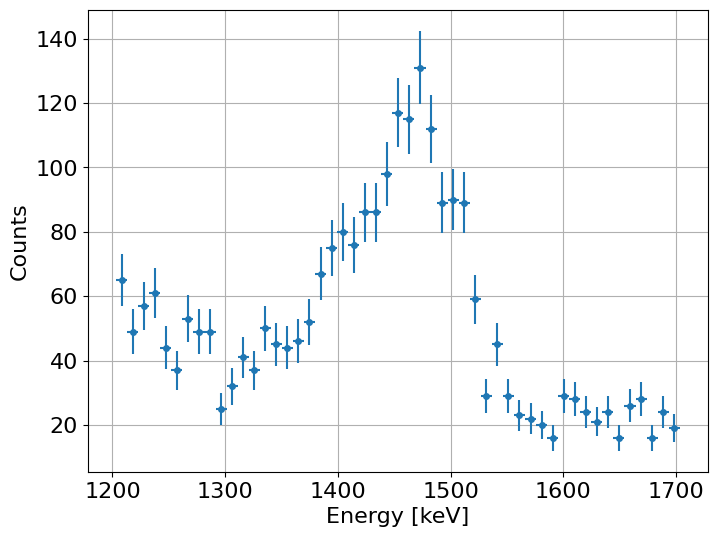

In [64]:
fig, ax = plt.subplots(figsize = (8, 6))

mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4
)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Counts")
ax.grid()
#ax.set_yscale("log")

In [65]:
def gaus (x, A, mu, sigma):
  return A * np.exp(-(x-mu)**2 / sigma**2)

def exponentially_decreasing (x, C, tau):
  return C * np.exp(-x / tau)

def gaus_exp (x, A, mu, sigma, C, tau):
  return gaus(x, A, mu, sigma) + exponentially_decreasing(x, C, tau)

In [68]:
lsq1 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus_exp
)

m1 = Minuit(lsq1, A = 100, mu = 1460, sigma = 50, C = 50, tau = 50)
m1.migrad()
m1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 82.58 (χ²/ndof = 1.8)      │              Nfcn = 501              │
│ EDM = 5.12e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │    86     │     4     │            │            │         │         │       │
│ 1 │ mu    │ 1.4593e3  │ 0.0024e3  │            │            │         │         │       │
│ 2 │ sigma │   60.6    │    3.0    │            │            │         │         │       │
│ 3 │ C     │  0.72e3   │  0.20e3   │            │            │         │         │       │
│ 4 │ tau   │    460    │    40     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │        A       mu    sigma        C      tau │
├───────┼──────────────────────────────────────────────┤
│     A │     19.6        2       -6       69      -17 │
│    mu │        2     5.56       -3       76      -14 │
│ sigma │       -6       -3     9.31       59      -19 │
│     C │       69       76       59 3.95e+04   -8.3e3 │
│   tau │      -17      -14      -19   -8.3e3 1.78e+03 │
└───────┴──────────────────────────────────────────────┘

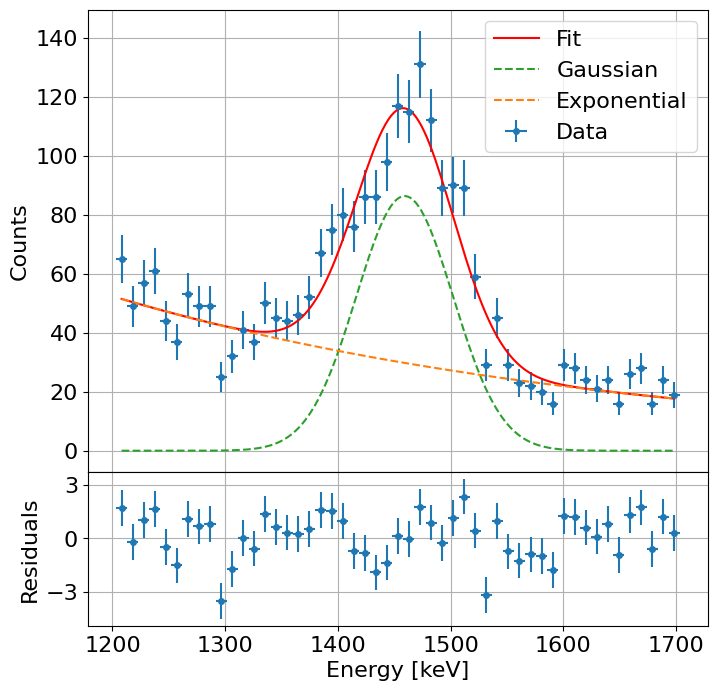

In [87]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus_exp(x, *m1.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m1.values[:3]), label = "Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m1.values[3:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus_exp(rebinned_energy[mask], *m1.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

Il chi quadrato su gradi di libertà di questo fit è venuto di 1.8.

Possiamo provare ad utilizzare due gaussiane invece che una, in quanto è previsto che ad energie di circa 1400 ci sia un'altra linea spettrale della radioattività ambientale.

In [88]:
def gaus2_exp (x, A1, mu1, sigma1, A2, mu2, sigma2, C, tau):
  return gaus(x, A1, mu1, sigma1) + gaus(x, A2, mu2, sigma2) + exponentially_decreasing(x, C, tau)

In [89]:
lsq2 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus2_exp
)
m2 = Minuit(lsq2, A1 = 100, mu1 = 1460, sigma1 = 50, A2 = 10, mu2 = 1400, sigma2 = 50, C = 50, tau = 460)
m2.migrad()
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 77.82 (χ²/ndof = 1.8)      │             Nfcn = 1384              │
│ EDM = 0.0157 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    90     │     4     │            │            │         │         │       │
│ 1 │ mu1    │ 1.4573e3  │ 0.0024e3  │            │            │         │         │       │
│ 2 │ sigma1 │   65.2    │    3.3    │            │            │         │         │       │
│ 3 │ A2     │    160    │    90     │            │            │         │         │       │
│ 4 │ mu2    │    750    │    90     │            │            │         │         │       │
│ 5 │ sigma2 │    370    │    50     │            │            │         │         │       │
│ 6 │ C      │    31     │    14     │            │            │         │         │       │
│ 7 │ tau    │    4e3    │    4e3    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2        C      tau │
├────────┼─────────────────────────────────────────────────────────────────────────┤
│     A1 │     18.3        1       -5       35       13      -26       -5  1.163e3 │
│    mu1 │        1     5.99       -4      -53        0       36        1     -552 │
│ sigma1 │       -5       -4     11.1       83       10      -56       -6  1.262e3 │
│     A2 │       35      -53       83 7.49e+03     -5e3   -0.6e3        0      9e3 │
│    mu2 │       13        0       10     -5e3 8.67e+03   -3.1e3  -0.07e3     21e3 │
│ sigma2 │      -26       36      -56   -0.6e3   -3.1e3 2.78e+03  -0.09e3   15.2e3 │
│      C │       -5        1       -6        0  -0.07e3  -0.09e3      193 -55.15e3 │
│    tau │  1.163e3     -552  1.262e3      9e3     21e3   15.2e3 -55.15e3 1.61e+07 │
└────────┴─────────────────────────────────────────────────────────────────────────┘

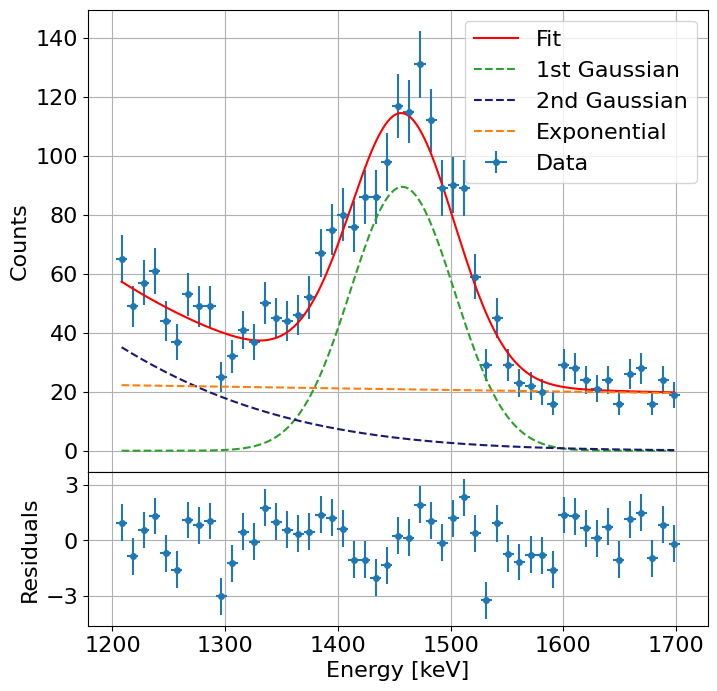

In [90]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus2_exp(x, *m2.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m2.values[:3]), label = "1st Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, gaus(x, *m2.values[3:6]), label = "2nd Gaussian", color = "midnightblue", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m2.values[6:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus2_exp(rebinned_energy[mask], *m2.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

Non ha fatto ciò che volevamo!

Infatti, come media della seconda gaussiana ha dato 750, che è totalmente al di fuori del nostro range.

Esiste un modo per poter limitare l'intervallo di variabilità dei parametri nel fit.

In [93]:
lsq2 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus2_exp
)
m2 = Minuit(lsq2, A1 = 100, mu1 = 1460, sigma1 = 50, A2 = 10, mu2 = 1400, sigma2 = 50, C = 50, tau = 460)
m2.limits["mu2"] = (1330, 1440)
m2.limits["A2"] = (0, 1000)
m2.migrad()
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 65.41 (χ²/ndof = 1.5)      │             Nfcn = 1392              │
│ EDM = 1.56 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    91     │    10     │            │            │         │         │       │
│ 1 │ mu1    │  1.473e3  │  0.009e3  │            │            │         │         │       │
│ 2 │ sigma1 │    45     │     7     │            │            │         │         │       │
│ 3 │ A2     │    34     │    11     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  1.404e3  │  0.019e3  │            │            │  1330   │  1440   │       │
│ 5 │ sigma2 │    39     │    21     │            │            │         │         │       │
│ 6 │ C      │  0.89e3   │  0.13e3   │            │            │         │         │       │
│ 7 │ tau    │    425    │    19     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2        C      tau │
├────────┼─────────────────────────────────────────────────────────────────────────┤
│     A1 │      107      -80       50  -0.07e3  -0.17e3  -0.19e3   0.17e3  -0.02e3 │
│    mu1 │      -80     86.3      -60       90      180      180     -150       10 │
│ sigma1 │       50      -60     52.3      -70     -130     -130      140      -20 │
│     A2 │  -0.07e3       90      -70      129   0.19e3   0.17e3  -0.18e3   0.02e3 │
│    mu2 │  -0.17e3      180     -130   0.19e3      393    0.4e3   -0.3e3        0 │
│ sigma2 │  -0.19e3      180     -130   0.17e3    0.4e3      438   -0.4e3        0 │
│      C │   0.17e3     -150      140  -0.18e3   -0.3e3   -0.4e3 1.72e+04   -2.5e3 │
│    tau │  -0.02e3       10      -20   0.02e3        0        0   -2.5e3      372 │
└────────┴─────────────────────────────────────────────────────────────────────────┘

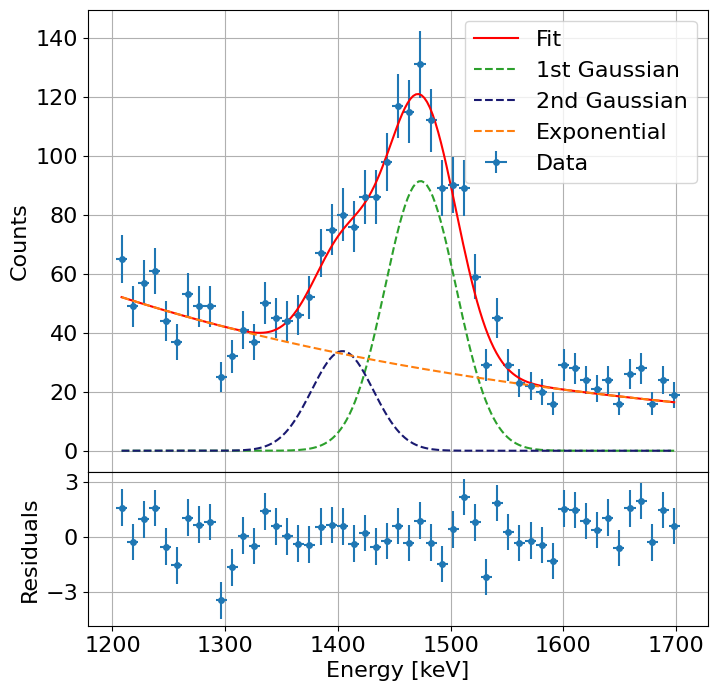

In [94]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus2_exp(x, *m2.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m2.values[:3]), label = "1st Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, gaus(x, *m2.values[3:6]), label = "2nd Gaussian", color = "midnightblue", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m2.values[6:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus2_exp(rebinned_energy[mask], *m2.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

Ora il fit è andato a buon fine!

Il chi quadrato su gradi di libertà è anche migliorato da 1.8 a 1.5.

Sono stati due fit a 5 gradi di libertà e 8 gradi di libertà, perciò il chi quadrato minimo si distribuisce secondo una distribuzione di chi quadrato a 3 gradi di libertà

In [95]:
from scipy.stats import chi2

In [106]:
m2.fval, m2.ndof,m2.fval/m2.ndof

(65.40828366348002, 43.0, 1.5211228758948843)

In [107]:
m1.fval, m1.ndof, m1.fval/m1.ndof

(82.58126334072523, 46.0, 1.7952448552331572)

17.17297967724521 3.0
0.000651143454171832


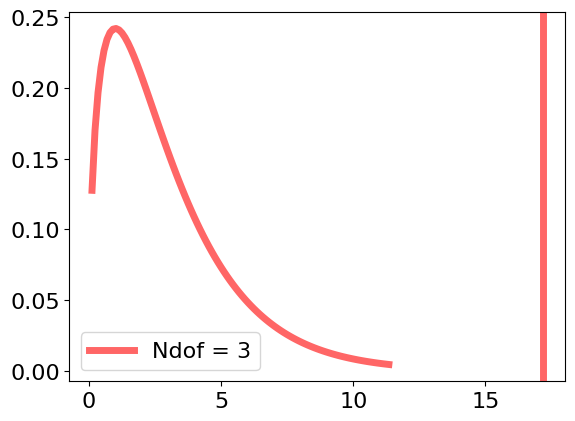

In [110]:
fval = - m2.fval + m1.fval
df = - m2.ndof + m1.ndof
print (fval, df)

fig, ax = plt.subplots()

x = np.linspace(chi2.ppf(0.01, df),
               chi2.ppf(0.99, df), 100)
ax.plot(x, chi2.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='Ndof = %d' % df);
ax.axvline(fval, color = "red", lw=5, alpha=0.6)
ax.legend();
print (1-chi2.cdf(fval, df))

Ne deduciamo che il miglioramento del fit con l'utilizzo di 2 gaussiane invece che una è significativo con livello di confidenza maggiore del 95%!

Dunque, possiamo dire che siamo stati in grado di osservare una riga spettrale a $1404 \pm 19$ keV. Infatti, ce ne sta una del bismuto-214 a 1408 keV, con branching ratio di 2.4.

Tuttavia, c'è anche da dire che cene sta un'altra, sempre del bismuto-214, ad energia di $1509$ keV, con un branching ratio di 2.1!

Dunque, conviene provare un fit con 3 gaussiane e vedere se il miglioramento nel fit è significativo.

In [112]:
def gaus3_exp (x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, C, tau):
  return gaus(x, A1, mu1, sigma1) + gaus(x, A2, mu2, sigma2) + gaus(x, A3, mu3, sigma3) + exponentially_decreasing(x, C, tau)

In [132]:
lsq3 = LeastSquares(
    x = rebinned_energy[mask],
    y = rebinned_counts[mask],
    yerror = np.sqrt(rebinned_counts[mask]),
    model = gaus3_exp
)
m3 = Minuit(lsq3, A1 = 100, mu1 = 1460, sigma1 = 20, A2 = 34, mu2 = 1403, sigma2 = 19, A3 = 40, mu3 = 1510 , sigma3 = 20 , C = 50, tau = 460)
m3.limits["sigma1"] = (0, 27)
m3.limits["sigma2"] = (0, 27)
m3.limits["mu2"] = (1370, 1430)
m3.limits["A2"] = (0, 1000)
m3.limits["mu3"] = (1460, 1540)
m3.limits["A3"] = (0, 1000)
m3.migrad()
m3.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 61.91 (χ²/ndof = 1.5)      │             Nfcn = 2591              │
│ EDM = 3.94e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    90     │    40     │            │            │         │         │       │
│ 1 │ mu1    │  1.459e3  │  0.014e3  │            │            │         │         │       │
│ 2 │ sigma1 │   27.0    │    2.3    │            │            │    0    │   27    │       │
│ 3 │ A2     │    47     │     8     │            │            │    0    │  1000   │       │
│ 4 │ mu2    │  1.404e3  │  0.006e3  │            │            │  1370   │  1430   │       │
│ 5 │ sigma2 │   27.0    │    1.7    │            │            │    0    │   27    │       │
│ 6 │ A3     │    57     │    16     │            │            │    0    │  1000   │       │
│ 7 │ mu3    │  1.500e3  │  0.019e3  │            │            │  1460   │  1540   │       │
│ 8 │ sigma3 │    26     │    18     │            │            │         │         │       │
│ 9 │ C      │  0.61e3   │  0.17e3   │            │            │         │         │       │
│ 10│ tau    │    490    │    50     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2       A3      mu3   sigma3        C      tau │
├────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     A1 │  1.6e+03   0.54e3  0.46e-3      250      210  0.95e-3  -0.58e3    0.8e3  -0.70e3   -1.2e3    0.4e3 │
│    mu1 │   0.54e3      189  0.16e-3       90       80  0.36e-3  -0.20e3   0.26e3  -0.24e3  -0.40e3   0.15e3 │
│ sigma1 │  0.46e-3  0.16e-3 0.000137  0.05e-3  0.05e-3        0 -0.22e-3  0.24e-3 -0.21e-3 -0.37e-3  0.13e-3 │
│     A2 │      250       90  0.05e-3     67.8       40  0.13e-3     -100      120     -110     -190       70 │
│    mu2 │      210       80  0.05e-3       40     42.5  0.16e-3      -90      110     -100     -130       50 │
│ sigma2 │  0.95e-3  0.36e-3        0  0.13e-3  0.16e-3 0.000152 -0.39e-3  0.49e-3 -0.44e-3 -0.86e-3  0.29e-3 │
│     A3 │  -0.58e3  -0.20e3 -0.22e-3     -100      -90 -0.39e-3      260  -0.28e3   0.25e3   0.48e3  -0.18e3 │
│    mu3 │    0.8e3   0.26e3  0.24e-3      120      110  0.49e-3  -0.28e3      374  -0.34e3   -0.6e3    0.2e3 │
│ sigma3 │  -0.70e3  -0.24e3 -0.21e-3     -110     -100 -0.44e-3   0.25e3  -0.34e3      317   0.58e3  -0.21e3 │
│      C │   -1.2e3  -0.40e3 -0.37e-3     -190     -130 -0.86e-3   0.48e3   -0.6e3   0.58e3 2.77e+04   -7.7e3 │
│    tau │    0.4e3   0.15e3  0.13e-3       70       50  0.29e-3  -0.18e3    0.2e3  -0.21e3   -7.7e3  2.2e+03 │
└────────┴────────────────────────────────────────────────────────────────────────────────────────────────────┘

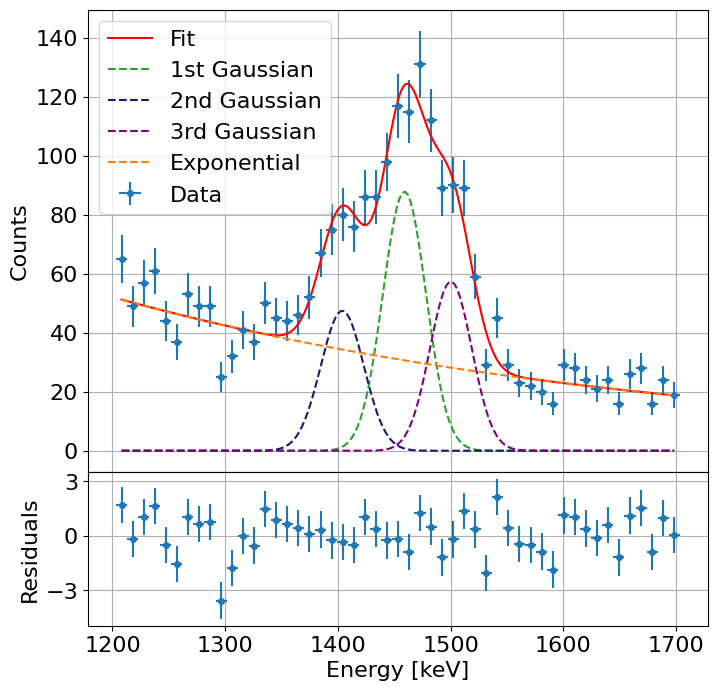

In [133]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8), sharex = True, gridspec_kw={"height_ratios":[3, 1]})
fig.subplots_adjust(hspace = 0)

ax = axs[0]
mask = (rebinned_energy > 1200) * (rebinned_energy < 1700)
ax.errorbar(
    rebinned_energy[mask],
    rebinned_counts[mask],
    xerr = (rebinned_energy[1] - rebinned_energy[0])/2,
    yerr = np.sqrt(rebinned_counts[mask]),
    ls = "None",
    marker = "o",
    ms = 4,
    label = "Data",
)
ax.set_ylabel("Counts")
ax.grid()

x = np.linspace(rebinned_energy[mask][0], rebinned_energy[mask][-1], 200)
ax.plot(x, gaus3_exp(x, *m3.values), label = "Fit", color = "red")
ax.plot(x, gaus(x, *m3.values[:3]), label = "1st Gaussian", color = "tab:green", ls = "dashed")
ax.plot(x, gaus(x, *m3.values[3:6]), label = "2nd Gaussian", color = "midnightblue", ls = "dashed")
ax.plot(x, gaus(x, *m3.values[6:9]), label = "3rd Gaussian", color = "purple", ls = "dashed")
ax.plot(x, exponentially_decreasing(x, *m3.values[9:]), label = "Exponential", color = "tab:orange", ls = "dashed")
ax.legend()

ax = axs[1]
ax.errorbar(rebinned_energy[mask], (rebinned_counts[mask] - gaus3_exp(rebinned_energy[mask], *m3.values))/np.sqrt(rebinned_counts[mask]), xerr = (rebinned_energy[1] - rebinned_energy[0])/2, yerr = 1,
            ls = "None",    marker = "o", ms = 4,)
ax.set_ylabel("Residuals")
ax.set_xlabel("Energy [keV]")
ax.yaxis.set_ticks([-3, 0, 3])
ax.grid()

In [138]:
np.trapz(gaus(x, *m3.values[:3]), x), np.trapz(gaus(x, *m3.values[3:6]), x), np.trapz(gaus(x, *m3.values[6:9]), x)

(4205.700154811034, 2271.9995378870826, 2658.8305135103346)

Questo fit invece non mi soddisfa particolarmente! Il chi quadro normalizzato è lo stesso del fit con 2 gaussiane, inoltre i picco a 1400 keV dovrebbe essere più intenso di quello a 1500 keV...

Vediamo se statisticamente è meglio o meno.

3.496889787063317 3.0
0.32116572908537866


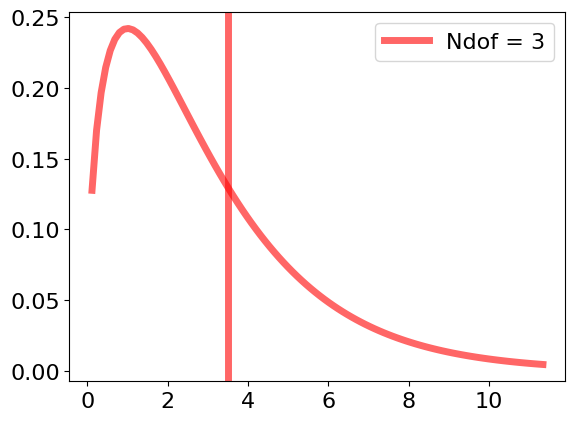

In [139]:
fval = - m3.fval + m2.fval
df = - m3.ndof + m2.ndof
print (fval, df)

fig, ax = plt.subplots()

x = np.linspace(chi2.ppf(0.01, df),
               chi2.ppf(0.99, df), 100)
ax.plot(x, chi2.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='Ndof = %d' % df);
ax.axvline(fval, color = "red", lw=5, alpha=0.6)
ax.legend();
print (1-chi2.cdf(fval, df))

In [147]:
from scipy.special import erfinv

def pval_to_sigma (pval):
  return erfinv(pval) * np.sqrt(2)

pval_to_sigma(0.32)

0.41246312944140484

Non lo è, perchè il p-valore è di 0.32, corrispondente a 0.42 sigma di significatività!